# Théorie des graphes

> Au vu de la nature des données issues de twitter, la théorie des graphes est une bonne approche pour tirer des informations de ces données. Dans ce notebook, on utilisera le package [NetworkX](https://networkx.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

df = pd.read_csv('graph_data.csv')
df.head()

,status_id_str,user_id_str,in_reply_to_user_id_str,in_reply_to_status_id_str
0,9030985626586855846,-652854001767642124,NaN,NaN
1,544315978398703647,5212031146057198528,NaN,NaN
2,-5031508206708971716,-355838202193138169,NaN,NaN
3,1865002324598914636,-4004577265331671325,NaN,NaN
4,2886056665371128633,-6176491263297020231,NaN,NaN


> Pour rappel, les colonnes correspondent aux informations suivantes:
>
> - `status_id_str`: id du tweet
> - `user_id_str`: id de l'utilisateur
> - `in_reply_to_user_id_str`: id de l'utilisateur dont le tweet a reçu une réponse
> - `in_reply_to_status_id_str`: id du tweet qui a reçu une réponse.

## Graphe des utilisateurs

> Nous allons créer un graphe des utilisateurs: les utilisateurs seront liés si un utilisateur a reçu une réponse d'un autre utilisateur.

In [2]:
user_graph = nx.from_edgelist(
    list(
        zip(
            df.loc[df['in_reply_to_status_id_str'].notna(), 'user_id_str'],
            df.loc[df['in_reply_to_status_id_str'].notna(), 'in_reply_to_user_id_str']
        )
    )
)

print('nb nodes:',  len(user_graph))
print('nb edges:', len(user_graph.edges))

nb nodes: 4387
nb edges: 3024


## Représentation du graphe

> Pour représenter un graphe, on doit définir un layout, c'est-à-dire une disposition des noeuds, puis représenter noeuds et arêtes (nodes, edges).

In [3]:
# création du layout (peut prendre du temps)
user_layout = nx.spring_layout(user_graph)

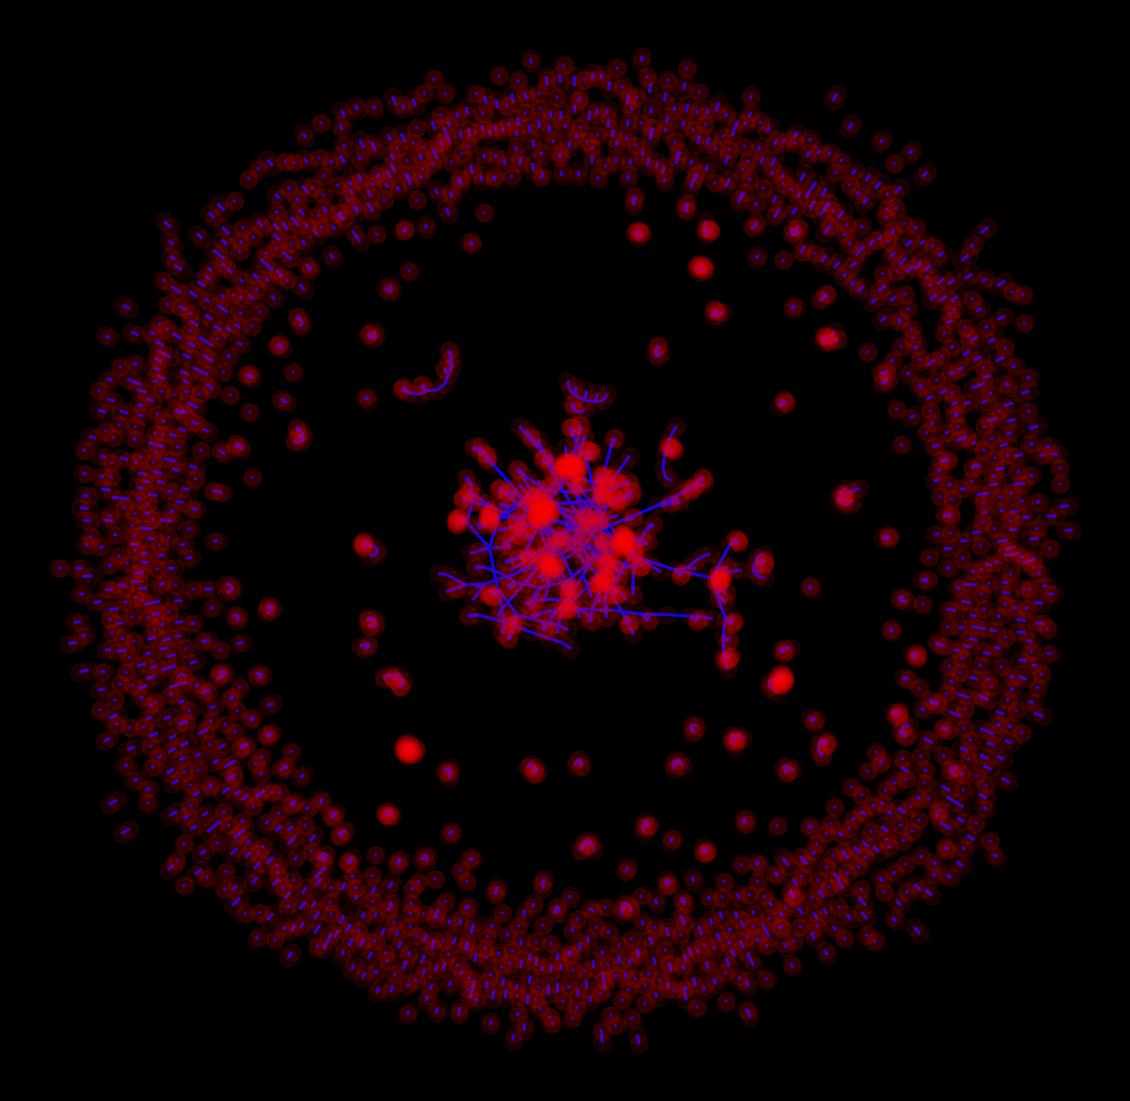

In [4]:
with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(user_graph, pos=user_layout, node_color='red', alpha=.1)
    nx.draw_networkx_edges(user_graph, pos=user_layout, edge_color='blue', width=3)
    plt.axis('off')
    plt.show()

> Pour rappel, cette figure représente les utilisateurs en rouge et dessine un trait bleu entre deux utilisateurs si l'un des deux a répondu à l'autre.
>
> Le graphe est difficilement exploitable tel quel: on remarque un groupe au milieu et de nombreux couples d'utilisateurs sur la périphérie. On peut choisir d'étudier le plus grand composant connecté, c'est-à-dire l'ensemble des noeuds entièrement connectés entre eux.

In [5]:
def get_greatest_connected_graph(graph):
    connected_components = list(nx.connected_components(graph))
    greatest_connected_component = max(connected_components, key=lambda x: len(x))
    greatest_connected_component = nx.from_edgelist(filter(lambda x: x[0] in greatest_connected_component, graph.edges))
    return greatest_connected_component

In [6]:
greatest_connected_component = get_greatest_connected_graph(user_graph)

In [7]:
layout2 = nx.spring_layout(greatest_connected_component)

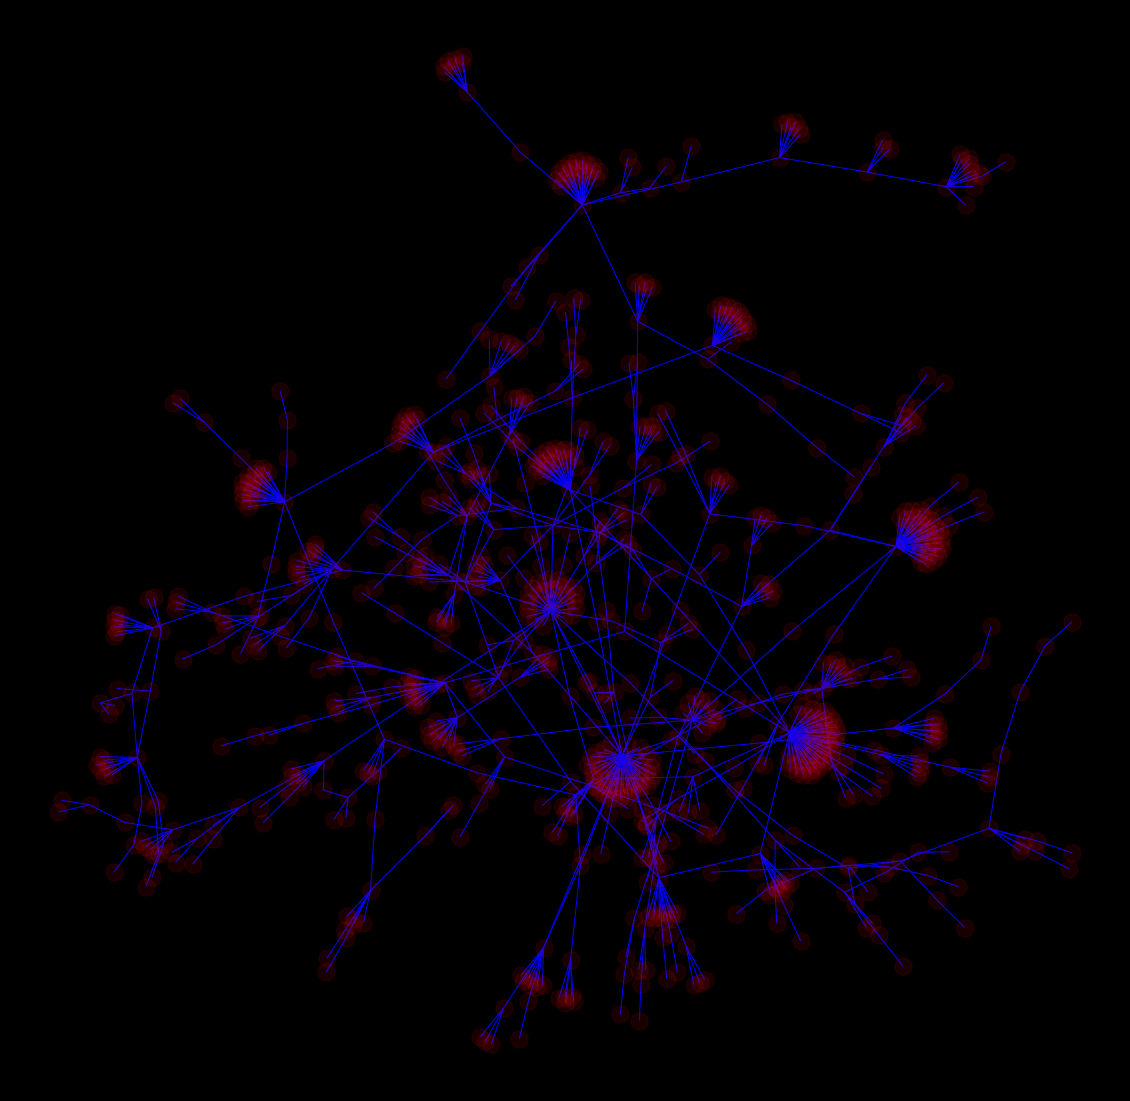

In [8]:
with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(greatest_connected_component, pos=layout2, node_color='red', alpha=.1)
    nx.draw_networkx_edges(greatest_connected_component, pos=layout2, edge_color='blue', width=1)
    plt.savefig('twitter.png')
    plt.axis('off')
    plt.show()

> La suite des analyses sera conduite sur ce sous-graphe plutôt que sur tout le graphe pour limiter le temps de calcul mais on pourrait tout à fait effectuer ces calculs sur l'entiéreté du graphe.

## Distribution du nombre de voisins

> En théorie des graphes, les voisins d'un noeud sont les noeuds directement connectés à ce noeud.

In [9]:
graph = greatest_connected_component

print('nb nodes:',  len(graph))
print('nb edges:', len(graph.edges))

nb nodes: 926
nb edges: 943


In [10]:
nb_neighbors = pd.Series([len(list(graph.neighbors(i))) for i in graph.nodes])
nb_neighbors.describe()

count    926.000000
mean       2.036717
std        4.083289
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       62.000000
dtype: float64

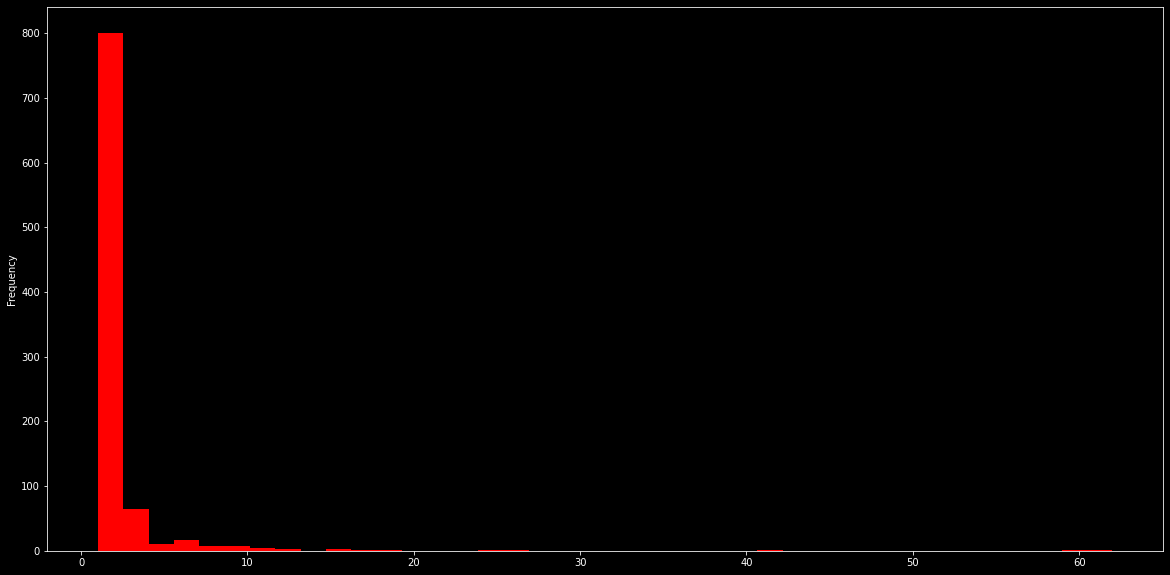

In [11]:
with plt.style.context('dark_background'):
    nb_neighbors.plot.hist(figsize=(20, 10), bins=40, color='r')
    plt.show()

## Étude des triangles

> Les triangles sont intéressant en théorie des graphes: il représent le fait que trois noeuds sont chacun connecté aux autres.

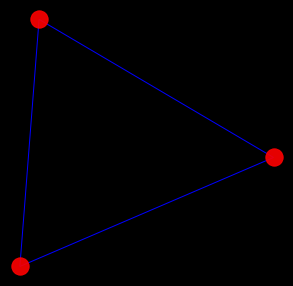

In [12]:
# exemple de triangle

triangle_graph = nx.from_edgelist([['a', 'b'], ['a', 'c'], ['c', 'b']])

layout3 = nx.spring_layout(triangle_graph)

with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(triangle_graph, pos=layout3, node_color='red', alpha=.9)
    nx.draw_networkx_edges(triangle_graph, pos=layout3, edge_color='blue', width=1)
    plt.axis('off')
    plt.show()

In [13]:
triangles = sum(nx.triangles(graph).values()) / 3
print(triangles)

0.0


> Dans ce graphe, nous n'avons aucun triangle.

## Étude de la centralité des noeuds

> La notion de centralité est une notion complexe en théorie des graphes qui permet d'évaluer à quel point un noeud est connecté au reste des graphe. Une approche pour évaluer cette centralité est l'utilisation de l'algorithme PageRank.

In [14]:
page_rank_scores = nx.pagerank(graph)


In [15]:
print('Node with highest PageRank:')
highest_page_rank_node = max(page_rank_scores, key=lambda x: page_rank_scores.get(x))
print('Node:', highest_page_rank_node)
print('Score:', page_rank_scores[highest_page_rank_node])

Node with highest PageRank:
Node: 6.769888965427915e+18
Score: 0.029552143096701216


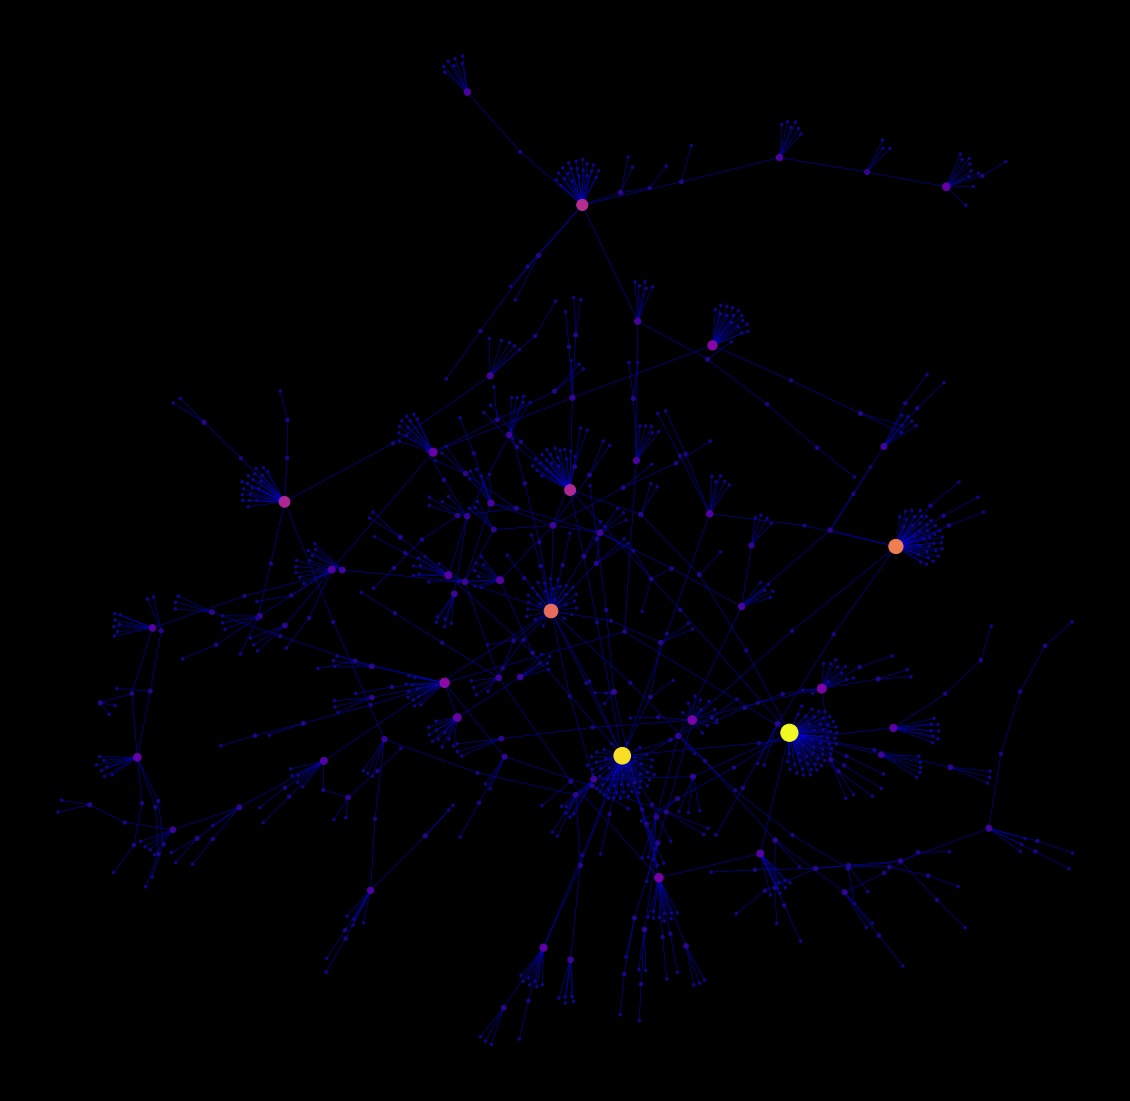

In [16]:
with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(graph, pos=layout2,
                           node_color=list(page_rank_scores.values()),
                           alpha=1,
                           node_size=[i * 10000 for i in list(page_rank_scores.values())],
                           cmap='plasma'
                          )
    nx.draw_networkx_edges(graph, pos=layout2, edge_color='blue', width=.4)

    
    plt.axis('off')
    plt.show()

> Sans surprise, les noeuds les plus importants selon PageRank semblent être les mieux connectés mais certains noeuds peu connectés vont avoir un score PageRank plus élevé que leur nombre de voisins.

## Étude de la connectivité du graphe

> Une méthode pour mesure à quel point le graphe est connecté consiste à supprimer les noeuds les plus connectés et à mesurer le nombre de composants connectés: 
> 
> 1. On supprime le noeud avec le plus grand nombre de voisin.
> 2. On calcule le nombre de composants connectés.
> 3. On recommence
>
> Cette étude permet de voir à quelle vitesse un graphe peut se retrouver morcelé.


In [17]:
def get_most_connected_node(graph):
    neighbors = {i: len(list(nx.neighbors(graph, i))) for i in graph}
    most_connected_node = max(neighbors, key=lambda x: neighbors.get(x))
    return most_connected_node

In [18]:
nb_connected_components = []

temp_graph = graph.copy()

most_connected_node = get_most_connected_node(temp_graph)

temp_graph.remove_node(most_connected_node)


In [19]:
temp_layout = nx.spring_layout(temp_graph)

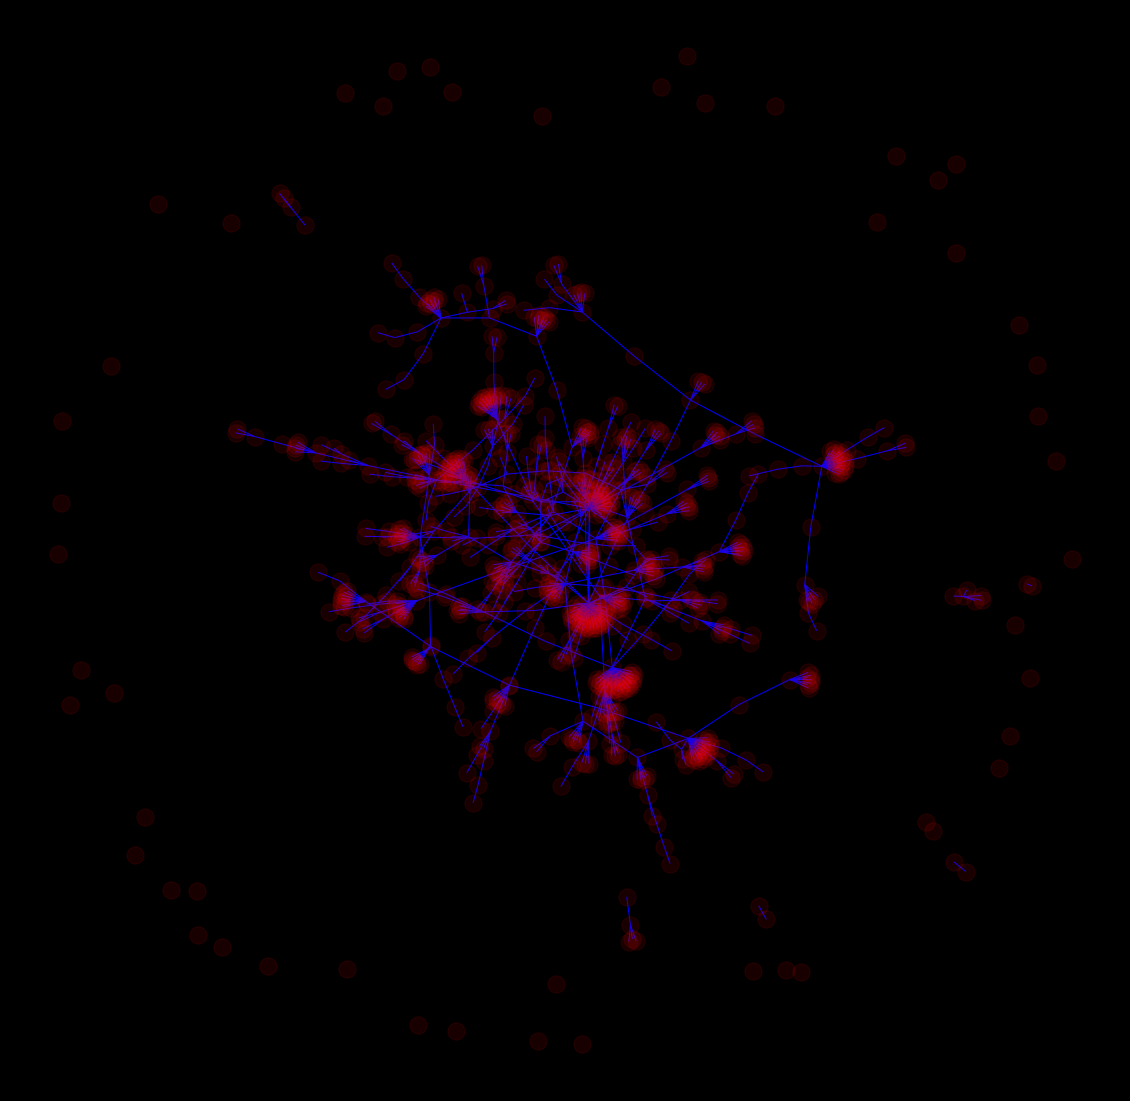

In [20]:
with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(temp_graph, pos=temp_layout, node_color='red', alpha=.1)
    nx.draw_networkx_edges(temp_graph, pos=temp_layout, edge_color='blue', width=1)
    plt.axis('off')
    plt.show()

> On remarque qu'en enlevant un seul noeud, on a déja de nombreux noeuds qui se retrouvent tout à fait isolés du reste du graphe. On peut essayer de répéter l'opération 100 fois en comptant le nombre de composants connectés à chaque fois:

In [21]:
nb_connected_components = [1]

temp_graph = graph.copy()

for i in range(100):
    most_connected_node = get_most_connected_node(temp_graph)

    temp_graph.remove_node(most_connected_node)
    
    nb_connected_components.append(len(list(nx.connected_components(temp_graph))))

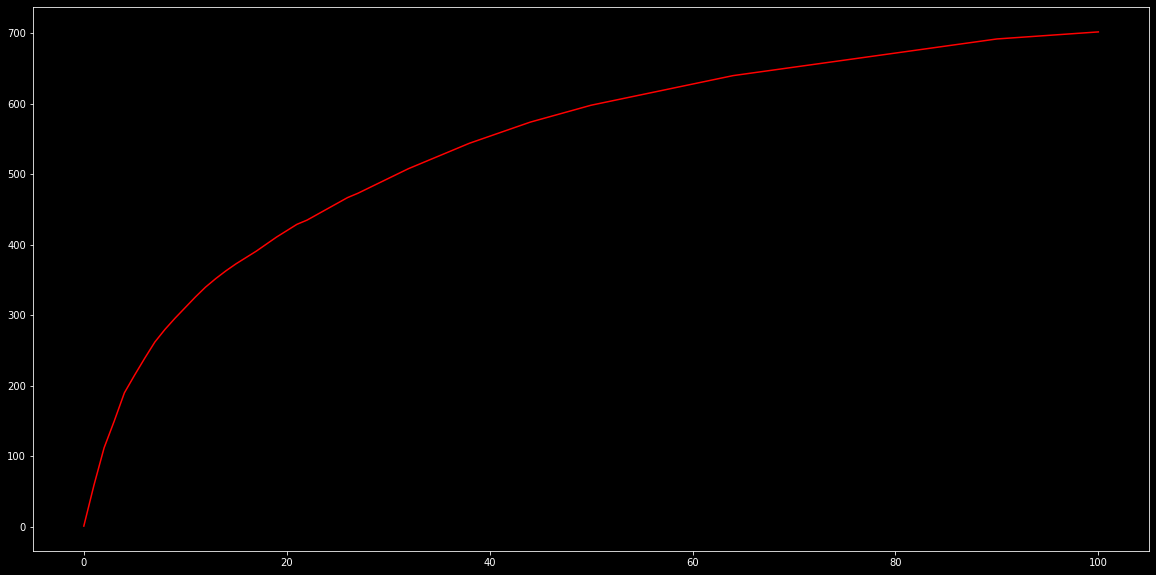

In [22]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 10))
    plt.plot(nb_connected_components, color='r')
    plt.show()

> On remarque qu'au bout de la suppression du 20e noeud le plus connecté, on a déja 400 composants connectés. En complément, on peut regarder l'évolution du degré moyen (nombre de voisin) dans ce graphe avec cette même technique. On peut aussi mesurer la déviation standard de ce degré.

In [23]:

temp_graph = graph.copy()

degrees = list(dict(nx.degree(temp_graph)).values())

avg_degree = [np.mean(degrees)]
std_degree = [np.std(degrees)]




for i in range(100):
    most_connected_node = get_most_connected_node(temp_graph)

    temp_graph.remove_node(most_connected_node)
    
    degrees = list(dict(nx.degree(temp_graph)).values())
    
    avg_degree.append(np.mean(degrees))
    std_degree.append(np.std(degrees))
    

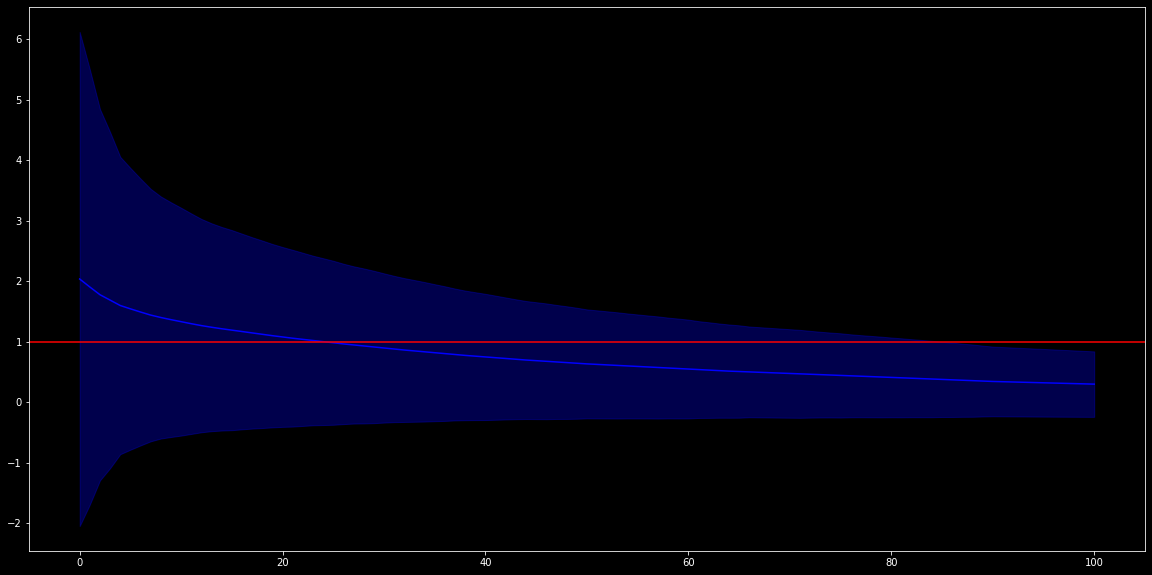

In [24]:
top_line = np.array(avg_degree) + np.array(std_degree)
bottom_line = np.array(avg_degree) - np.array(std_degree)

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 10))
    plt.plot(avg_degree, color='b')
    plt.fill_between(range(101), bottom_line, top_line, color='b', alpha=.3)
    plt.axhline(1, color='r')
    plt.show()

> On peut voir qu'au dela du 20e noeud supprimé, on a un degré moyen en dessous de 2. Ce qui semble suggérer q'une grande partie des noeuds ne soient plus reliés qu'à un seul autre noeud. Essayons de se représenter ce graphe après 25 suppressions:

In [25]:
temp_graph = graph.copy()


for i in range(25):
    most_connected_node = get_most_connected_node(temp_graph)

    temp_graph.remove_node(most_connected_node)


In [26]:
temp_layout = nx.spring_layout(temp_graph)

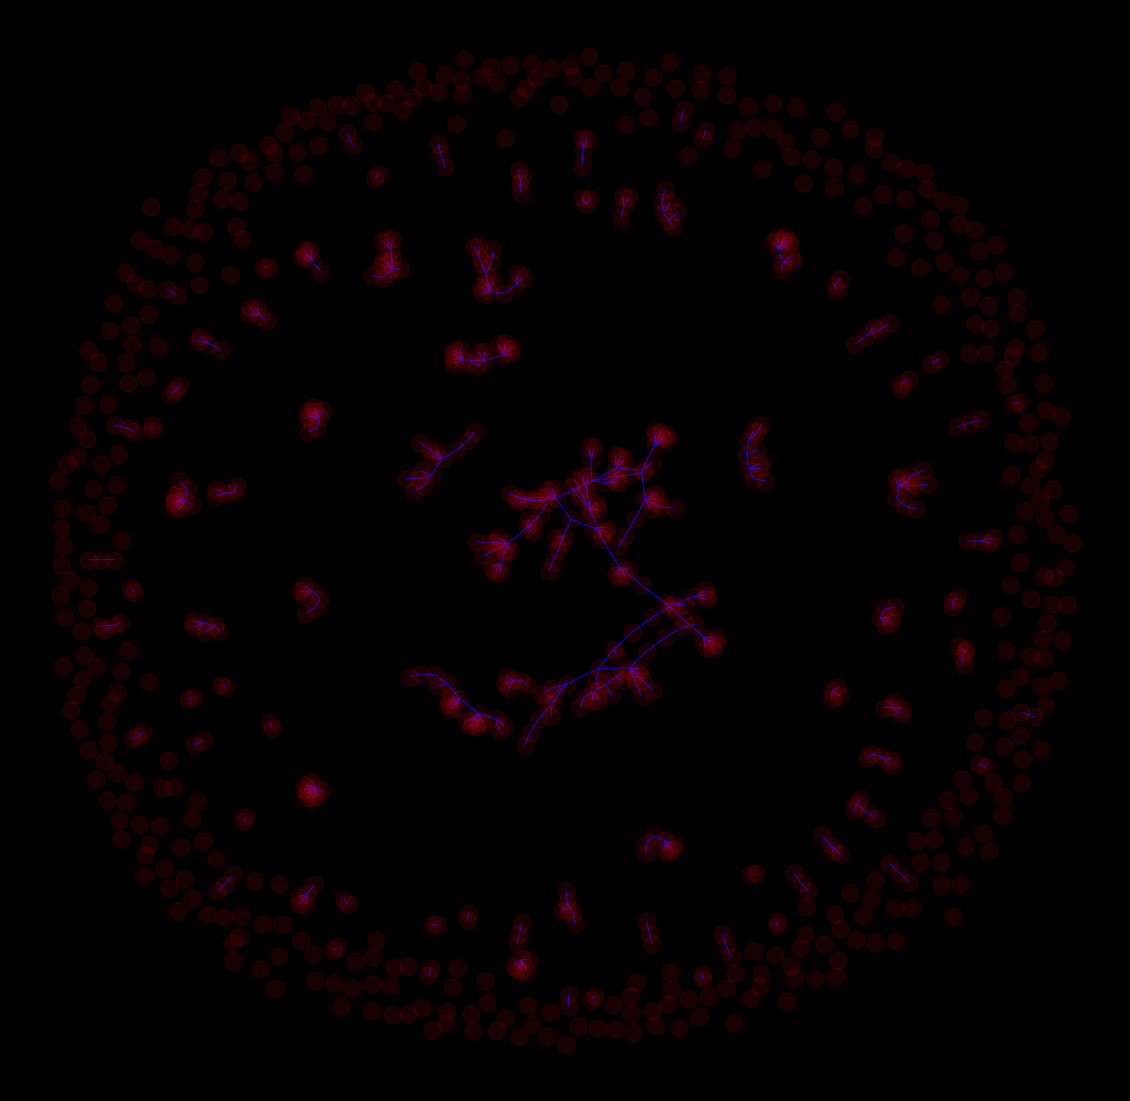

In [27]:
with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(temp_graph, pos=temp_layout, node_color='red', alpha=.1)
    nx.draw_networkx_edges(temp_graph, pos=temp_layout, edge_color='blue', width=1)
    plt.axis('off')
    plt.show()

> On a toujours un composant connecté au milieu de cette représentation mais ...

In [28]:
gcg = get_greatest_connected_graph(temp_graph)

print(len(gcg))

64


> Il ne contient plus que 64 noeuds contre les 900 noeuds environ à l'origine... On a donc un graphe qui est fortement polarisé autour de certains noeuds. D'un point de vue de l'analyse, si on traquait la diffusion de fausses informations et que ce graphe représentait les personnes qui participent à cette diffusion, il suffirait de neutraliser une vingtaine de comptes.

## Graph clustering

> On peut aussi faire du clustering à partie de ce graphe. Une approche peut être d'utiliser la méthode de Louvain. Une autre à utiliser du Graph Embedding (Node2Vec) puis d'utiliser un algorithme de KMeans classique. 


In [29]:
# ! pip3 install node2vec

In [30]:
from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(graph, dimensions=30, walk_length=16, num_walks=200)

# Learn embeddings 
model = node2vec.fit(window=5, min_count=1)



Computing transition probabilities:   0%|          | 0/926 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


> Une fois qu'on a appris des embeddings pour ces noeuds, on peut exécuter l'algorithme de KMeans

In [31]:
df_embedding = pd.DataFrame([model.wv[str(n)] for n in graph])
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.558735,-0.101077,1.610073,-0.130230,1.859252,1.158168,0.995425,-0.219956,-1.049191,0.504316,...,-0.916517,-0.577597,1.984652,1.821302,0.113067,0.757979,0.324004,0.307602,1.617995,-0.982310
1,-0.638942,0.232906,0.962401,0.308350,1.668806,1.172311,1.154719,0.213738,-1.229708,0.512334,...,-0.700238,-0.446828,1.585565,1.653535,0.691943,0.409707,0.305565,0.244174,1.830872,-0.881314
2,-0.628594,0.092091,1.490443,0.040620,1.766178,1.319634,1.084936,-0.295166,-1.425540,0.617469,...,-0.682728,-0.791601,1.618974,2.199087,0.338298,0.618359,0.482231,0.174368,1.641660,-1.026816
3,-0.564937,0.337340,0.377371,0.098500,1.165017,0.433994,1.386561,-0.071967,-0.830685,0.215350,...,-0.211129,-0.311601,1.336501,1.633138,0.685413,1.222792,0.320096,0.343081,1.703181,-0.493596
4,0.163610,-0.078169,1.042985,0.148084,0.932944,0.414091,-0.067947,-0.137949,-0.834665,-0.053159,...,-0.047036,-0.867523,-0.783254,0.701238,0.692430,0.554507,0.672018,1.707950,-0.060498,-0.290274


In [32]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4)

kmeans_model.fit(df_embedding)

KMeans(n_clusters=4)

In [33]:
clusters = {
    list(graph.nodes)[i] : kmeans_model.predict(df_embedding)[i]
    for i in range(len(graph.nodes))
}

inverse_clusters = {
    i: [node for node in clusters if clusters[node] == i]
     for i in range(8) 
}

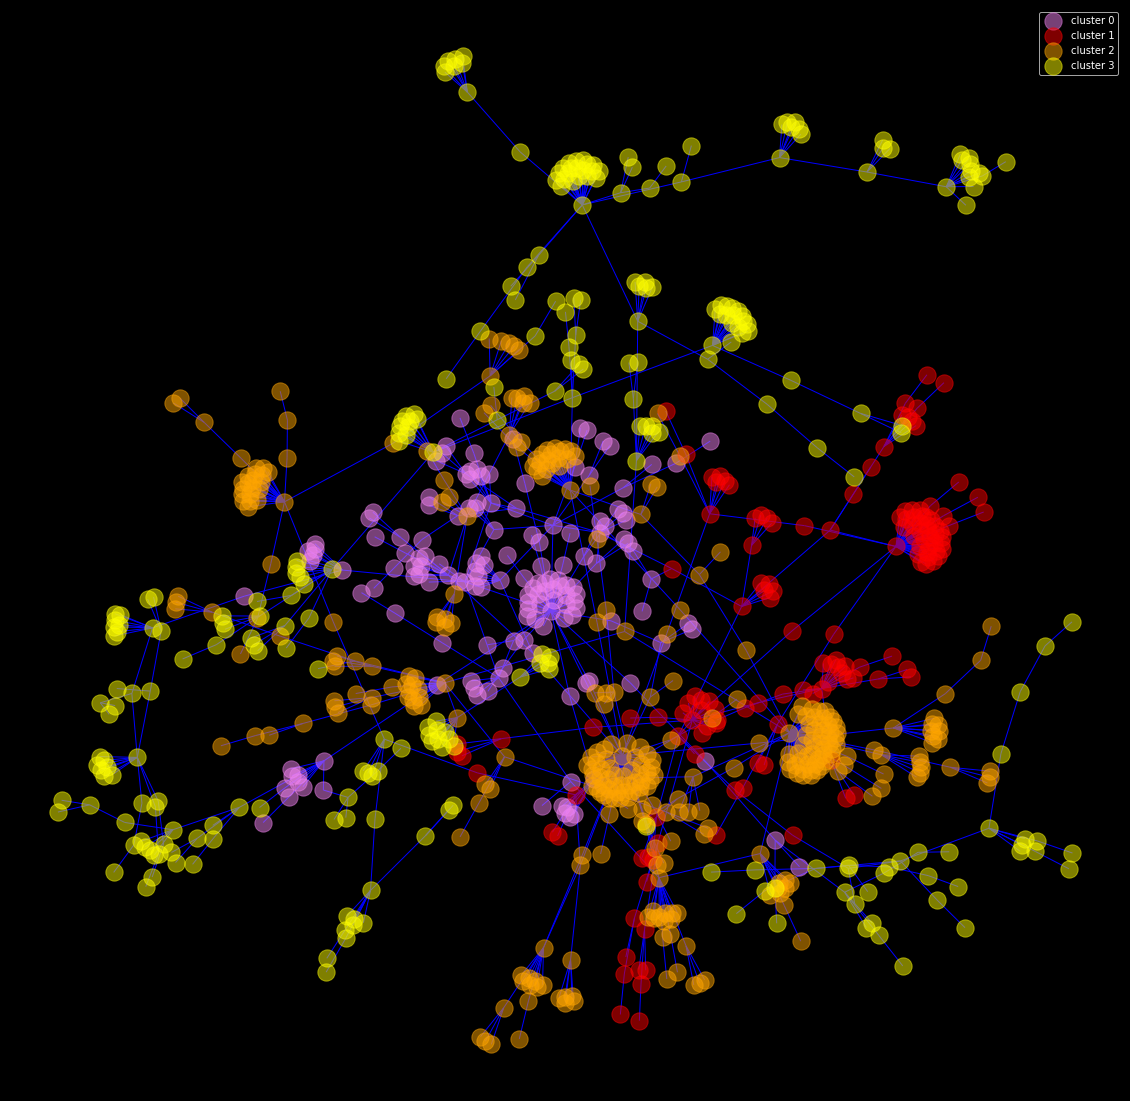

In [34]:
colors = ['violet', 'red', 'orange', 'yellow']

with plt.style.context('dark_background'):
    figure = plt.figure(figsize=(20, 20))
    for i in range(kmeans_model.n_clusters):
        nx.draw_networkx_nodes(
            graph, 
            nodelist=inverse_clusters[i],
            pos=layout2, 
            node_color=colors[i],
            alpha=.5,
            label='cluster {}'.format(i)
        )
    nx.draw_networkx_edges(graph, pos=layout2, edge_color='blue', width=1)
    plt.legend(loc='best')
    plt.axis('off')
    plt.show()

> Ce clustering n'est sans doute pas parfait et mériterait d'être précisé mais il donne une idée des techniques que l'on peut utiliser.